# Deep Learning for NLP - Project

In [1]:
import pandas as pd
import io
import os
import scipy
import numpy as np
import re
from scipy import linalg
import random as rn
import string 
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [2]:
PATH_TO_DATA = os.getcwd()

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
            
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}        
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        # New variable 
        self.list_words = list(self.word2vec.keys())
        
    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        
        words_and_score = []
        pivot = self.word2vec[w]
        
        for i in range(len(self.embeddings)):
            tmp_val = self.embeddings[i]
            words_and_score.append([self.list_words[i], Word2vec.score_1(pivot,tmp_val)])
            
        words_and_score.sort(key = lambda x : x[1], reverse = True)
        
        top_K_words = []
        
        for j in range(K):
            top_K_words.append(words_and_score[j+1][0])
        
        return top_K_words
    
    
    def KNN(self,pivot, K=5):
        # K most similar words: self.score  -  np.argsort 
        words_and_score = []
        
        for i in range(len(self.embeddings)):
            tmp_val = self.embeddings[i]
            words_and_score.append([self.list_words[i], Word2vec.score_1(pivot, tmp_val)])
            
        words_and_score.sort(key = lambda x : x[1], reverse = True)
        
        top_K_words = []
        
        for j in range(K):
            top_K_words.append(words_and_score[j+1][0])
            
        return top_K_words
                        
    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        
        w1_vec = self.word2vec[w1]
        w2_vec = self.word2vec[w2]
        
        return np.dot(w1_vec,w2_vec)/(np.linalg.norm(w1_vec) * np.linalg.norm(w2_vec))
    
    def score_1(w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        
        return np.dot(w1,w2)/(np.linalg.norm(w1) * np.linalg.norm(w2))


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'london', 'berlin', 'tokyo']
['austria', 'europe', 'german', 'berlin', 'poland']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help      
                
        sentence_emb = []

        if idf is False:
            for sentence in sentences:
                admitted_words = []
                for w in sentence:
                    try:
                        admitted_words.append(self.w2v.word2vec[w])
                    except:
                        pass
                if(len(admitted_words) == 0):
                    sentence_emb.append([0]*300)
                else:
                    sentence_emb.append(np.sum([wv for wv in admitted_words], axis = 0)/len(admitted_words))
                
        else:
            for sentence in sentences:
                admitted_words = []
                for w in sentence:
                    try:
                        admitted_words.append( (w, self.w2v.word2vec[w]) )
                    except:
                        pass
                if(len(admitted_words) == 0):
                    sentence_emb.append([0]*300)
                else:
                    normalization = np.sum([idf[w[0]] for w in admitted_words])
                    sentence_emb.append(np.sum([ [float(idf[w[0]])*component for component in w[1]] for w in admitted_words],axis = 0)/normalization)
                
        return np.vstack(sentence_emb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        s_encode = self.encode([s], idf)
        
        # K most similar words: self.score  -  np.argsort 
        most_similar_words = []
        
        for i in range(len(keys)):
            tmp_val = keys[i]
            most_similar_words.append((sentences[i], np.dot(s_encode,tmp_val)/(np.linalg.norm(s_encode) * np.linalg.norm(tmp_val))))
        
        most_similar_words.sort(key = lambda x : x[1], reverse = True)
            
        #How to get the sentence for a given vector
        for i in range(K):
            print(most_similar_words[i+1][0])

        return most_similar_words[1:K+1][0]

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        v1 = self.encode([s1],idf)
        v2 = self.encode([s2],idf)
        
        return np.dot(v1,v2.T)/(np.linalg.norm(v1) * np.linalg.norm(v2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        
        # Decleare the idf dictionary
        idf = {}
        # Normalized dictionary
        n_idf = {}
        
        for sent in sentences:
             for w in set(sent): 
                idf[w] = idf.get(w, 0) + 1 
                
        for word in list(idf.keys()):
            n_idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
            
        return n_idf

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=250000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
file_sentences = "sentences.txt"

f = open(file_sentences,'r')
data = f.read().split('\n')
exclude = set(string.punctuation)
data_cleaned = [(''.join(ch for ch in line if ch not in exclude)) for line in data]
sentences = [word_tokenize(line) for line in data_cleaned if (len(line)>0)]
f.close()
    
# Build idf scores for each word
idf = {} if True else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print('' if not sentences else sentences[10])

s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])

idf = s2v.build_idf(sentences)
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)

['1', 'smiling', 'african', 'american', 'boy']
['an', 'african', 'american', 'man', 'smiling']
['a', 'little', 'african', 'american', 'boy', 'and', 'girl', 'looking', 'up']
['african', 'american', 'woman', 'bouncing', 'black', 'basketball']
['an', 'afican', 'american', 'woman', 'standing', 'behind', 'two', 'small', 'african', 'american', 'children']
['a', 'girl', 'in', 'black', 'hat', 'holding', 'an', 'african', 'american', 'baby']
['an', 'african', 'american', 'man', 'smiling']
['an', 'african', 'american', 'man', 'is', 'sitting']
['a', 'little', 'african', 'american', 'boy', 'and', 'girl', 'looking', 'up']
['an', 'afican', 'american', 'woman', 'standing', 'behind', 'two', 'small', 'african', 'american', 'children']
['a', 'girl', 'in', 'black', 'hat', 'holding', 'an', 'african', 'american', 'baby']


array([[0.45262547]])

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

# DOWNLOAD
# LOAD
n_words = 50000
w2v_en = Word2vec('wiki.en.vec',n_words)
w2v_fr = Word2vec('wiki.fr.vec',n_words)

In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)
words_en = set(w2v_en.list_words)
words_fr = set(w2v_fr.list_words)
words_common = words_en.intersection(words_fr)

n_words_common = len(words_common)
n_words_distinct = n_words - n_words_common

lst_en_words_distinct = list(words_en.difference(words_common))
lst_fr_words_distinct = list(words_fr.difference(words_common))
lst_words_common = list(words_common)

d = len(w2v_en.word2vec[lst_en_words_distinct[0]])

X = np.zeros((d,n_words_common))
Y = np.zeros((d,n_words_common))

for i in range(n_words_common):
    X[:,i] = w2v_fr.word2vec[lst_words_common[i]]
    Y[:,i] = w2v_en.word2vec[lst_words_common[i]]

In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector
U, s, Vh = linalg.svd(Y.dot(X.T))
W = U.dot(Vh)

In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above
K = 5
n_showed_words = 10

print("** Pick a french word and give me the top K translations **")
# Pick a french word and give me the top K translations
for j in range(n_showed_words):
    my_index = np.random.randint(n_words)
    my_word = w2v_fr.list_words[my_index]
    print("French word: "+my_word)
    related_words = w2v_en.KNN(W.dot(w2v_fr.word2vec[my_word]))
    print("Top K english-related words are: ")
    for l in range(K):
        print("-> "+related_words[l])
print("** Pick a english word and give me the top K translations **")
# Pick an english word and give me the top K translations
for j in range(n_showed_words):
    my_index = np.random.randint(n_words)
    my_word = w2v_en.list_words[my_index]
    print("English word: "+my_word)
    related_words = w2v_fr.KNN((W.T).dot(w2v_en.word2vec[my_word]))
    print("Top K french-related words are: ")
    for l in range(K):
        print("-> "+related_words[l])

** Pick a french word and give me the top K translations **
French word: fmi
Top K english-related words are: 
-> macroeconomic
-> monetary
-> eurozone
-> opec
-> oecd
French word: fermeture
Top K english-related words are: 
-> reopened
-> reopen
-> closure
-> closing
-> closures
French word: angulaire
Top K english-related words are: 
-> perpendicular
-> curvature
-> amplitude
-> dimensionless
-> velocity
French word: monnet
Top K english-related words are: 
-> moreau
-> leclerc
-> mitterrand
-> jean
-> françois
French word: lavedan
Top K english-related words are: 
-> foix
-> gascony
-> aveyron
-> navarre
-> occitan
French word: oricon
Top K english-related words are: 
-> heatseekers
-> chart
-> billboard
-> r&b/hip
-> peaking
French word: longueuil
Top K english-related words are: 
-> quebec
-> sherbrooke
-> gatineau
-> rivières
-> montreal
French word: agrégée
Top K english-related words are: 
-> normale
-> école
-> sorbonne
-> ecole
-> doctorate
French word: océanienne
Top K engli

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
def data_pp_1(fname,case):
    f = open(fname,'r')
    data = f.read().split('\n')
    exclude = set(string.punctuation)
    data_cleaned = [ (''.join(ch for ch in line if ch not in exclude)) for line in data]
    #If we have the labels
    if(case):
        sent = [word_tokenize(line[1:]) for line in data_cleaned if len(line) > 0]
        labels = [int(line[0]) for line in data_cleaned if len(line) > 0] 
        f.close()
        return sent,labels
    else:
        sent = [word_tokenize(line) for line in data_cleaned]
        f.close()
        return sent
    
file_name_train = "/Users/notebooks_deepl/nlp_project/data/SST/stsa.fine.train.csv"
file_name_test = "/Users/notebooks_deepl/nlp_project/data/SST/stsa.fine.test.X.csv"
file_name_dev = "/Users/notebooks_deepl/nlp_project/data/SST/stsa.fine.dev.csv"

sent_train, labels_train = data_pp_1(file_name_train,True)
sent_dev, labels_dev = data_pp_1(file_name_dev,True)
sent_test = data_pp_1(file_name_test,False)

In [12]:
# 2 - Encode sentences with the BoV model above

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=150000)
s2v = BoV(w2v)

sent_emb_train = s2v.encode(sent_train, s2v.build_idf(sent_train))
sent_emb_dev = s2v.encode(sent_dev, s2v.build_idf(sent_dev))
sent_emb_test = s2v.encode(sent_test, s2v.build_idf(sent_test))

In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

feat_name = [ "f_"+str(i) for i in range(300)]

df_train = pd.DataFrame(sent_emb_train, columns = feat_name)
df_train["class"] = labels_train
df_dev = pd.DataFrame(sent_emb_dev, columns = feat_name)
df_dev["class"] = labels_dev
df_test = pd.DataFrame(sent_emb_test, columns = feat_name)

# Building up the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

X_train, Y_train = df_train[feat_name].values, df_train['class'].values

clf_LR = LogisticRegression(C = 10, max_iter=10000,solver='lbfgs',multi_class='multinomial', penalty ='l2')

clf_LR.fit(X_train, Y_train)

print("--> Train")
print("The f1_score is: "+str(f1_score(Y_train, clf_LR.predict(X_train), average='macro'))) 
print("The accuracy is: "+str((accuracy_score(Y_train, clf_LR.predict(X_train))))) 

X_dev, Y_dev = df_dev[feat_name].values, df_dev['class'].values

print("--> Test")
print("The f1_score is: "+str(f1_score(Y_dev, clf_LR.predict(X_dev), average='macro'))) 
print("The accuracy is: "+str((accuracy_score(Y_dev, clf_LR.predict(X_dev)))))


print("With a PCA")

clf_LR_PCA = LogisticRegression(C = 10, max_iter=10000,solver='lbfgs',multi_class='multinomial', penalty ='l2')

pca = PCA(n_components = 120)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)


clf_LR_PCA.fit(X_train_PCA, Y_train)

print("--> Train")
print("The f1_score is: "+str(f1_score(Y_train, clf_LR_PCA.predict(X_train_PCA), average='macro'))) 
print("The accuracy is: "+str((accuracy_score(Y_train, clf_LR_PCA.predict(X_train_PCA))))) 

X_dev, Y_dev = df_dev[feat_name].values, df_dev['class'].values

X_dev_PCA = pca.transform(X_dev)

print("--> Test")
print("The f1_score is: "+str(f1_score(Y_dev, clf_LR_PCA.predict(X_dev_PCA), average='macro'))) 
print("The accuracy is: "+str((accuracy_score(Y_dev, clf_LR_PCA.predict(X_dev_PCA)))))


--> Train
The f1_score is: 0.4709425796983484
The accuracy is: 0.49929775280898875
--> Test
The f1_score is: 0.3674148302479298
The accuracy is: 0.3996366939146231
With a PCA
--> Train
The f1_score is: 0.4160345162745509
The accuracy is: 0.4610252808988764
--> Test
The f1_score is: 0.35571935591550596
The accuracy is: 0.40236148955495005


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

X_test = df_train[feat_name].values
pred_labels_LR = clf_LR.predict(X_test)
print(pred_labels_LR)

file_out_LR = open("logistic_regression_predictions.txt","w+")
for i in range(len(pred_labels_LR)):
    file_out_LR.write(str(pred_labels_LR[i])+"\n")  
    
file_out_LR.close()

[4 1 1 ... 0 1 3]


In [15]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [16]:
import keras
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = os.getcwd()+"\data"

def data_pp_2(fname):
    f = open(fname,'r')
    text = f.read()
    data = text.split('\n')
    f.close()
    return data
    
file_name_train = "/Users/notebooks_deepl/nlp_project/data/SST/stsa.fine.train.csv"
file_name_test = "/Users/notebooks_deepl/nlp_project/data/SST/stsa.fine.test.X.csv"
file_name_dev = "/Users/notebooks_deepl/nlp_project/data/SST/stsa.fine.dev.csv"

text_train = data_pp_2(file_name_train)
text_dev = data_pp_2(file_name_dev)
text_test = data_pp_2(file_name_test)

In [18]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
n = 16000

def text_to_2Dint(text,n):
    in_pad = []
    labels = []
    for line in (line for line in text if len(line) > 1):
        in_pad.append(keras.preprocessing.text.one_hot(line[1:], n = n*1.3,filters=string.punctuation, lower=True, split=' '))
        labels.append(int(line[0]))
    return in_pad,labels

def text_to_2Dint_test(text,n):
    in_pad = []
    for line in (line for line in text if len(line) > 1):
        in_pad.append(keras.preprocessing.text.one_hot(line, n = n*1.3,filters=string.punctuation, lower=True, split=' '))
    return in_pad

in_pad_train,labels_train = text_to_2Dint(text_train,n)
in_pad_dev,labels_dev = text_to_2Dint(text_dev,n)
in_pad_test = text_to_2Dint_test(text_test,n)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [19]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

X_train_PAD = keras.preprocessing.sequence.pad_sequences(in_pad_train, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_dev_PAD = keras.preprocessing.sequence.pad_sequences(in_pad_dev, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)
X_test_PAD = keras.preprocessing.sequence.pad_sequences(in_pad_test, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)

## 4.2 - Design and train your model

In [20]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation
from keras.utils import np_utils

embed_dim  = 50  # word embedding dimension
nhid       = 15  # number of hidden units in the LSTM
vocab_size = int(n*1.3)  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='softmax'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(15, dropout=0.2, recurrent_dropout=0.2)`


In [21]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'RMSProp' # find the right optimizer #RMSProp
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1040000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                3960      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 80        
Total params: 1,044,040
Trainable params: 1,044,040
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

bs = 64
n_epochs = 6

Y_train_categorical = np_utils.to_categorical(labels_train,5)
Y_dev_categorical = np_utils.to_categorical(labels_dev,5)
history = model.fit(X_train_PAD, Y_train_categorical, batch_size=bs, epochs=n_epochs, validation_data=(X_dev_PAD, Y_dev_categorical))

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 16s 2ms/step - loss: 1.5732 - acc: 0.2860 - val_loss: 1.5622 - val_acc: 0.2779
Epoch 2/6
8544/8544 [==============================] - 13s 2ms/step - loss: 1.5173 - acc: 0.3460 - val_loss: 1.5020 - val_acc: 0.3460
Epoch 3/6
8544/8544 [==============================] - 13s 1ms/step - loss: 1.3969 - acc: 0.3977 - val_loss: 1.4226 - val_acc: 0.3787
Epoch 4/6
8544/8544 [==============================] - 13s 2ms/step - loss: 1.2629 - acc: 0.4748 - val_loss: 1.3955 - val_acc: 0.3951
Epoch 5/6
8544/8544 [==============================] - 15s 2ms/step - loss: 1.1504 - acc: 0.5414 - val_loss: 1.3888 - val_acc: 0.3942
Epoch 6/6
8544/8544 [==============================] - 14s 2ms/step - loss: 1.0487 - acc: 0.5943 - val_loss: 1.4128 - val_acc: 0.3942


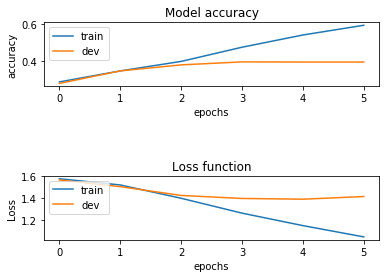

In [23]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

plt.subplot(3, 1, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Model accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train","dev"],loc ='upper left')

plt.subplot(3, 1, 3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(["train","dev"], loc ='upper left')

plt.show()

predictions = model.predict(X_test_PAD)

file = open("LSTM_predictions.txt","w+")
for line in predictions:
    file.write(str(np.argmax(line))+"\n")  
    
file.close()